In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & !(is.na(physeq.Bulk.m$Soil_Temp))),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")
physeq.Bulk.m = physeq.Bulk %>% sample_data



physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 128 samples ]
sample_data() Sample Data:       [ 128 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [5]:
%%R
get_l2fc = function(physeq.obj, Land_Management, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Land_Management == Land_Management),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Soil_Temp*Soil_Temp)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [6]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Land_Management) %>%
   distinct() %>%
    arrange(Land_Management) 
  

sdm

  Land_Management
1             NTH
2             NTR
3             PTH
4             PTR


In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 76 

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10
6             NTR               0.10


In [8]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [15,444 x 13]

   Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
             (chr)              (dbl)     (chr)          (dbl)      (dbl)
1              NTH               0.05  OTU.6089    0.088821402 0.06314356
2              NTH               0.05 OTU.17326   -0.031651009 0.06016730
3              NTH               0.05 OTU.14908    0.107269419 0.06428139
4              NTH               0.05  OTU.6041    0.019694265 0.06482397
5              NTH               0.05  OTU.6291    0.016688431 0.06047114
6              NTH               0.05  OTU.9364   -0.067445540 0.06442104
7              NTH               0.05   OTU.586    0.047062790 0.05408304
8              NTH               0.05 OTU.19007    0.026198753 0.05905875
9              NTH               0.05 OTU.36383   -0.030097304 0.05846607
10             NTH               0.05  OTU.1470    0.004400169 0.04245722
..             ...                ...       ...            ...        ..

In [9]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
        (dbl)
1 -0.01870906


In [10]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

      sdl2fc
       (dbl)
1 0.07273847


In [11]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [12]:
%%R
df.l2fc$Temp[df.l2fc$log2FoldChange > 0] = "increasing"
df.l2fc$Temp[df.l2fc$log2FoldChange <0] = "decreasing"

In [13]:
%%R
write.table(df.l2fc, "data/l2fc_TempCompiled", row.names = FALSE, sep = ",")

In [14]:
%%R
df.l2fc = read.table('data/l2fc_TempCompiled', sep =',', header = TRUE)

In [15]:
%%R
head(df.l2fc)

  Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1             NTH               0.05  OTU.6089     0.08882140 0.06314356
2             NTH               0.05 OTU.17326    -0.03165101 0.06016730
3             NTH               0.05 OTU.14908     0.10726942 0.06428139
4             NTH               0.05  OTU.6041     0.01969426 0.06482397
5             NTH               0.05  OTU.6291     0.01668843 0.06047114
6             NTH               0.05  OTU.9364    -0.06744554 0.06442104
       padj    Rank1            Rank2             Rank3           Rank4
1 0.9640580 k__Fungi  p__unidentified   c__unidentified o__unidentified
2 0.9945518 k__Fungi p__Basidiomycota c__Agaricomycetes    o__Boletales
3 0.8286571 k__Fungi p__Basidiomycota c__Agaricomycetes   o__Agaricales
4 0.9945518 k__Fungi p__Basidiomycota c__Agaricomycetes   o__Agaricales
5 0.9945518 k__Fungi p__Basidiomycota c__Agaricomycetes   o__Agaricales
6 0.9945518 k__Fungi p__Basidiomycota c__Agaricomycetes  

In [16]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
print(length(unique(r$OTU)))
print(length(df.l2fc$OTU))

[1] 44
[1] 15444


In [17]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Land_Management) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 3]

  sparsity_threshold Land_Management n_reject_hypo
               (dbl)          (fctr)         (int)
1               0.05             NTH             3
2               0.05             NTR            28
3               0.05             PTH             2
4               0.05             PTR             1
5               0.10             NTH             6
6               0.10             NTR            33


In [18]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold, Land_Management) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>%  as.data.frame

   sparsity_threshold Land_Management n_reject_hypo
1                0.05             NTH             3
2                0.05             NTR            28
3                0.05             PTH             2
4                0.05             PTR             1
5                0.10             NTH             6
6                0.10             NTR            33
7                0.10             PTH             2
8                0.10             PTR             1
9                0.15             NTH             5
10               0.15             NTR            35
11               0.15             PTH             2
12               0.15             PTR             1
13               0.20             NTH             6
14               0.20             NTR            36
15               0.20             PTH             2
16               0.20             PTR             1
17               0.25             NTH             6
18               0.25             NTR            36
19          

In [19]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.2


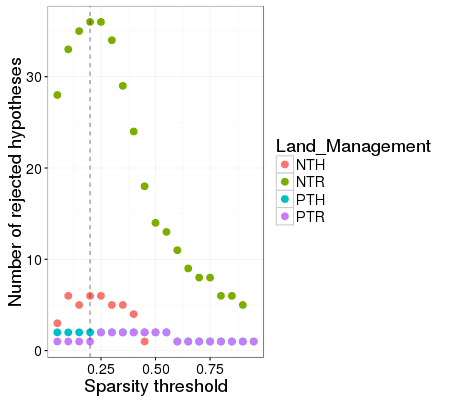

In [20]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo, color = Land_Management))+
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [21]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.15) 

df.l2fc.f %>% nrow

[1] 1627


In [22]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_Temp.txt'
write.table(df.l2fc.f, 'data/l2fc_Temp.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [23]:
%%R
df.l2fc = read.table('data/l2fc_Temp.txt', sep='\t', header = TRUE)

In [24]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [25]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 1627
[1] 635


In [26]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Temp, Land_Management) %>% summarise(resp = n())
resp %>% as.data.frame

        Temp Land_Management resp
1 decreasing             NTH    5
2 decreasing             NTR   34
3 decreasing             PTH    2
4 decreasing             PTR    1
5 increasing             NTR    1


In [27]:
%%R
resp = df.l2fc %>% ungroup %>% group_by(Temp, Land_Management) %>% filter(padj2 <=0.10) %>% group_by(Temp, Land_Management,
                                                                                                     Rank3) %>% 
        summarise(resp = n()) %>% ungroup %>% arrange(Rank3, -resp)
resp %>% as.data.frame

         Temp Land_Management              Rank3 resp
1  decreasing             NTR    Dothideomycetes   17
2  decreasing             NTR      Leotiomycetes    2
3  decreasing             NTH      Leotiomycetes    1
4  decreasing             NTR Microbotryomycetes    1
5  decreasing             NTR    Sordariomycetes    3
6  decreasing             PTH    Sordariomycetes    1
7  increasing             NTR    Sordariomycetes    1
8  decreasing             NTR    Tremellomycetes    6
9  decreasing             NTH    Tremellomycetes    2
10 decreasing             PTH    Tremellomycetes    1
11 decreasing             PTR    Tremellomycetes    1
12 decreasing             NTH       unidentified    1
13 decreasing             NTR       unidentified    1
14 decreasing             NTR               <NA>    4
15 decreasing             NTH               <NA>    1


In [28]:
%%R
df.l2fc %>% filter(padj2 <=0.10) %>% ungroup %>% group_by(Temp) %>% 
        summarise(mean_l2fc = mean(log2FoldChange), sd_l2fc = sd(log2FoldChange))


Source: local data frame [2 x 3]

        Temp  mean_l2fc   sd_l2fc
      (fctr)      (dbl)     (dbl)
1 decreasing -0.2754123 0.0606254
2 increasing  0.2013986        NA


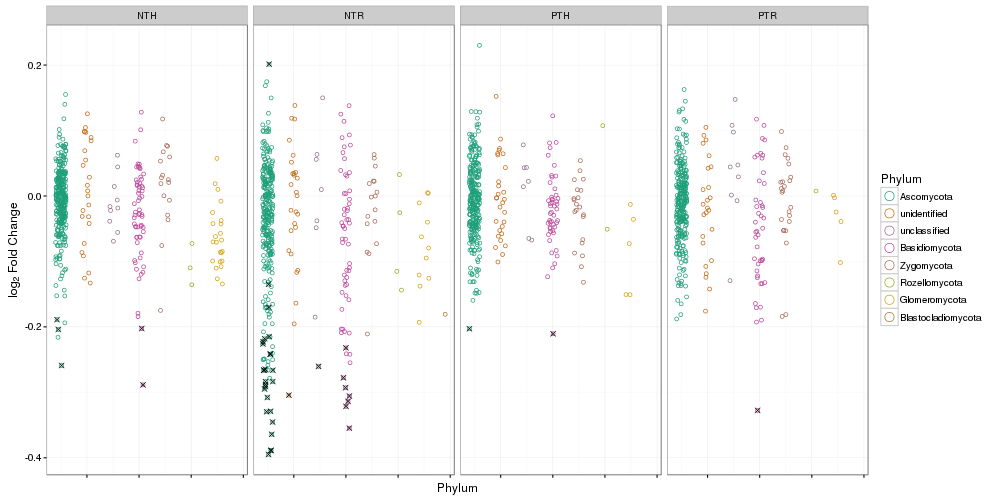

In [29]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

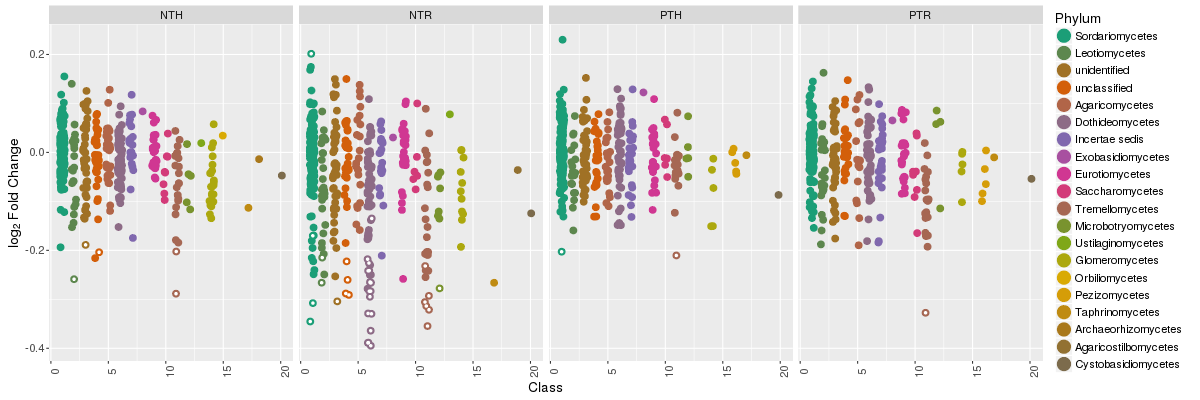

In [30]:
%%R -w 1200 -h 400
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 19, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "white", shape = 19, size = 1)

#p = p + geom_hline(y = 1.3)

#p = p + theme_bw()

p = p + labs(x = "Class", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) 


p

In [31]:
%%R
ggsave(filename = "data/figs/OTUs_Temp.png", plot = p, width =12, height =6)

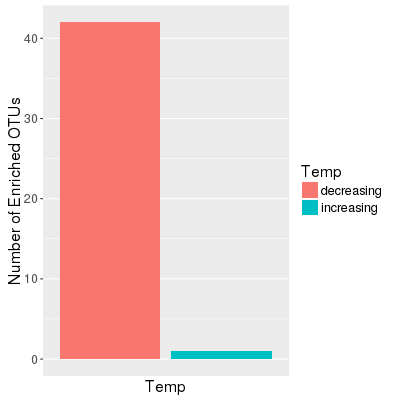

In [32]:
%%R -w 400 -h 400
p = ggplot(data = resp, aes(x = Temp, y = resp, fill = Temp)) +
    geom_bar(stat = 'identity') + 
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [33]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)